In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Konfiguracja

In [3]:
all_filenames = {
    'daily': {
        'pzu': './pzu_01-06-2010_01-01_2015.csv',
        'pxm': './pxm_01-06-2010_01-01_2015.csv',
        'itg': './itg_01-06-2010_01-01_2015.csv'
    },
    'weekly': {
        'pzu': './pzu_01-06-2010_01-01_2015_weekly.csv',
        'pxm': './pxm_01-06-2010_01-01_2015_weekly.csv',
        'itg': './itg_01-06-2010_01-01_2015_weekly.csv'
    },
    'monthly': {
        'pzu': './pzu_01-06-2010_01-01_2015_monthly.csv',
        'pxm': './pxm_01-06-2010_01-01_2015_monthly.csv',
        'itg': './itg_01-06-2010_01-01_2015_monthly.csv'
    }
}

frequency = 'monthly'
filenames = all_filenames[frequency]
phase_col_name = 'Zamkniecie'
date_col_name = 'Data'
date_format = '%Y-%m-%d'
usecols = [date_col_name] + [phase_col_name]
dates = ['2010-06-01', '2012-01-01', '2013-01-01', '2014-01-01']

### Wczytywanie danych

In [4]:
dateparse = lambda x: pd.datetime.strptime(x, date_format)

def csv_file_to_df(filename):
    assert(len(filename) > 0)
    df = pd.read_csv(filename, parse_dates=[date_col_name], date_parser=dateparse, usecols=usecols)
    return df.set_index(date_col_name)

In [5]:
data_frames = dict(((name, csv_file_to_df(filename)) for name, filename in filenames.items()))
assert(len(data_frames) == 3)
data_frames

{'itg':             Zamkniecie
 Data                  
 2010-06-30       71.00
 2010-07-30       76.50
 2010-08-31       65.80
 2010-09-30       71.00
 2010-10-29       74.60
 2010-11-30       79.75
 2010-12-31       79.70
 2011-01-31       78.00
 2011-02-28       80.95
 2011-03-31       84.10
 2011-04-29      107.00
 2011-05-31      118.90
 2011-06-30      118.00
 2011-07-29      110.40
 2011-08-31      104.90
 2011-09-30      103.90
 2011-10-31       98.80
 2011-11-30       99.00
 2011-12-30      114.40
 2012-01-31      128.50
 2012-02-29      137.30
 2012-03-30      152.90
 2012-04-30      138.00
 2012-05-31      133.40
 2012-06-29      141.00
 2012-07-31      134.00
 2012-08-31      127.70
 2012-09-28      137.60
 2012-10-31      160.50
 2012-11-30      169.40
 2012-12-31      184.50
 2013-01-31      189.70
 2013-02-28      179.90
 2013-03-29      188.00
 2013-04-30      197.00
 2013-05-31      252.50
 2013-06-28      264.00
 2013-07-31      315.00
 2013-08-30      287.00
 2013-09-

In [6]:
keys = list(data_frames.keys()) + ['bond']

## Wykresy, przedział czasowy od 2010-06-01 do 2015-01-01

Wybrałem ten sam przedział dla wszystkich akcji, bo z jednej strony ułatwiło mi to analizę zmian ich wartość, a z drugiej wg tego, co wyczytałem w Sieci, na polskim rynku optymalnym jest najczęściej horyzont 3-5 razy dłuższy od długości planowanej inwestycji.

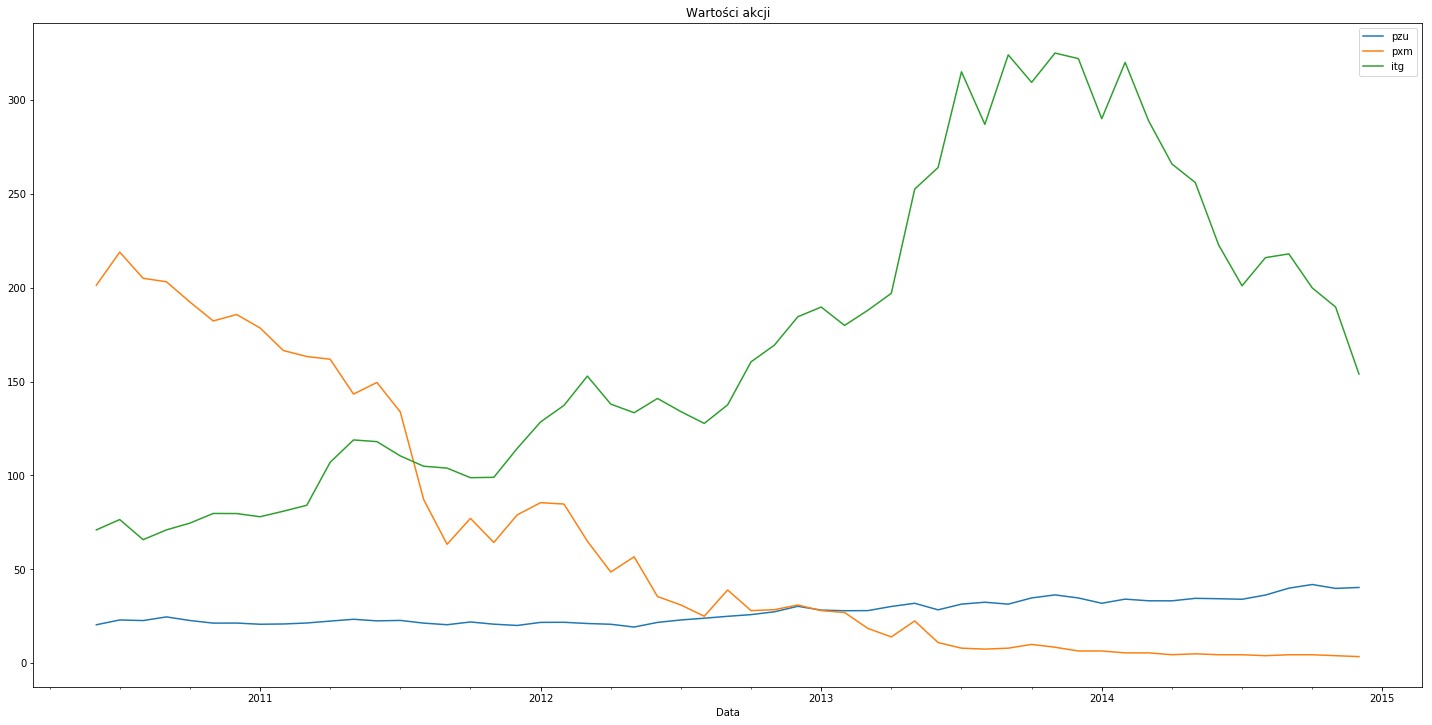

In [7]:
figsize = (20, 10)
kind = 'line'

def plot_data_frames(data_frames):
    for name, df in data_frames.items():
        df[phase_col_name].plot(kind=kind, figsize=figsize, label=name)

    plt.legend(bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.title("Wartości akcji")
    plt.show()
    

plot_data_frames(data_frames)

### Stopy zwrotu

In [8]:
dfs = {name: {'return': df.loc[df.index >= '2010-06-01'].pct_change()}  for name, df in data_frames.items()}
dfs
mixed_dfs = pd.concat({name: df['return'] for name, df in dfs.items()}, axis=1)
mixed_dfs.corr()

itg        pxm        pzu
               Zamkniecie Zamkniecie Zamkniecie
itg Zamkniecie   1.000000   0.184749   0.294264
pxm Zamkniecie   0.184749   1.000000   0.232355
pzu Zamkniecie   0.294264   0.232355   1.000000

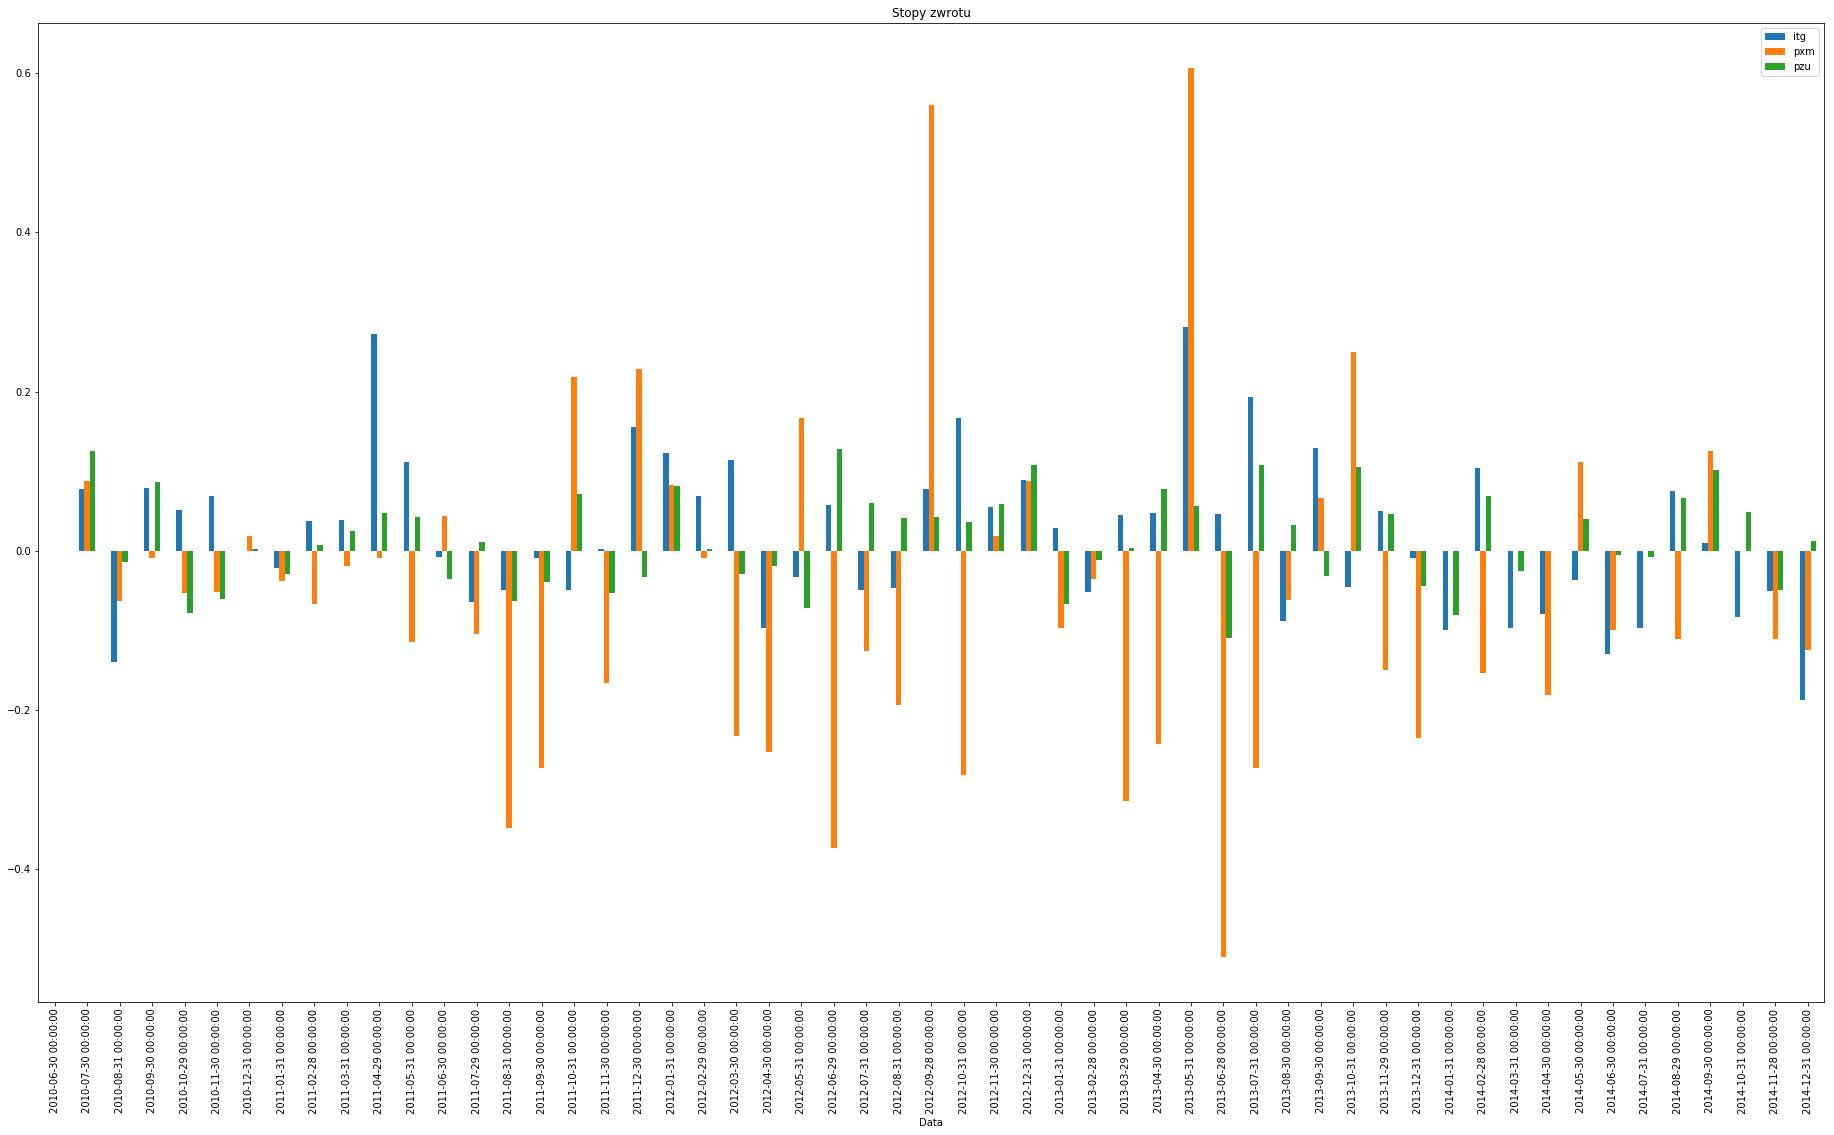

In [9]:
figsize = (32, 18)
kind = 'bar'

return_rates = {name: df.pct_change()['Zamkniecie'] for name, df in data_frames.items()}
pd.concat(return_rates, axis=1).plot(kind=kind, figsize=figsize, title='Stopy zwrotu')

### Wyliczenie parametrów

In [10]:
def get_correlation_matrix(data_frames, start_date):
    dfs = {name: {'return': df.pct_change()}  for name, df in data_frames.items()}
    mixed_dfs = pd.concat({name: df['return'].loc[df['return'].index >= start_date] for name, df in dfs.items()}, axis=1)
    return mixed_dfs.corr()

In [11]:
def calculate_parameters(data_frames, start_date):
    return {
        name: {
            'return': (1.0 + df.pct_change().loc[df.index >= start_date].mean()[0]) ** 12 - 1,
            'risk': df.pct_change().loc[df.index >= start_date].std()[0]
        }
        for name, df in data_frames.items()
    }

dates = ['2010-06-01', '2012-01-01', '2013-01-01', '2014-01-01']
parameters_per_date = {date: calculate_parameters(data_frames, date) for date in dates}
corr_matrices = {date: get_correlation_matrix(data_frames, date) for date in dates}

# dopisujemy dane obligacji
for date in dates:
    parameters_per_date[date]['bond'] = {'return': 0.02, 'risk': 0.00}
    corr_matrices[date]['bond'] = 0
    corr_matrices[date].loc[-1] = [0.0, 0.0, 0.0, 0.0]

# Wykresy akcji na podstawie wyliczonych stóp zwrotu i ryzyk

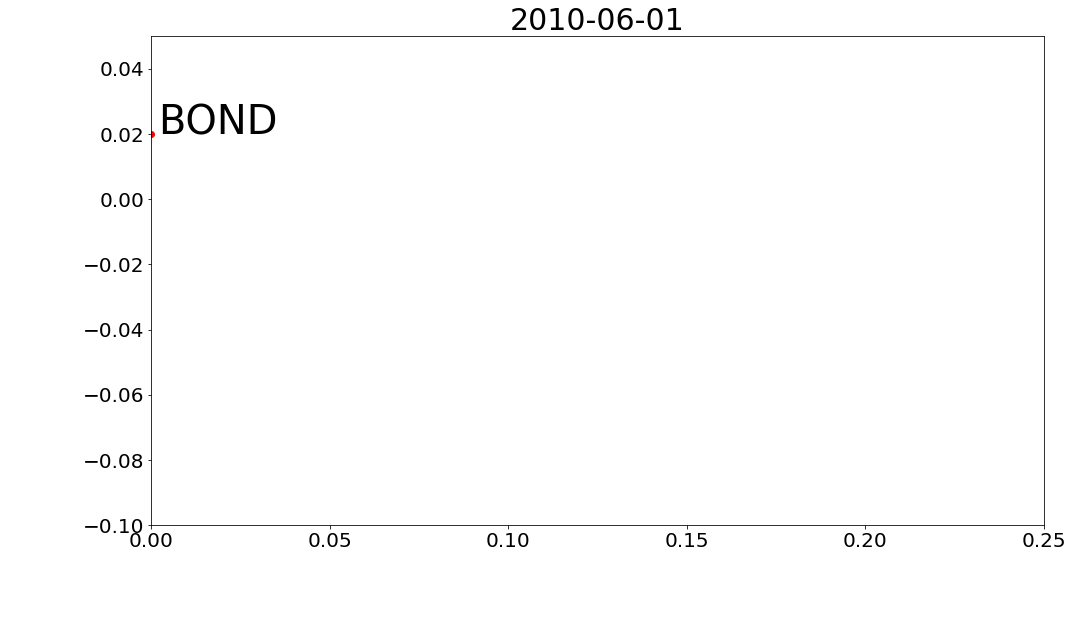

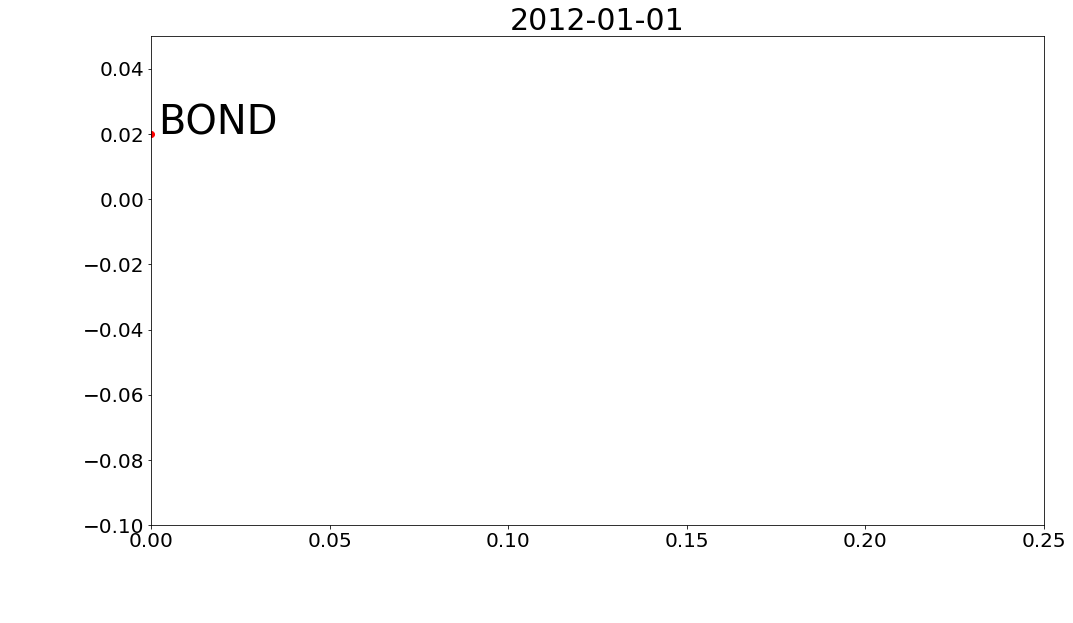

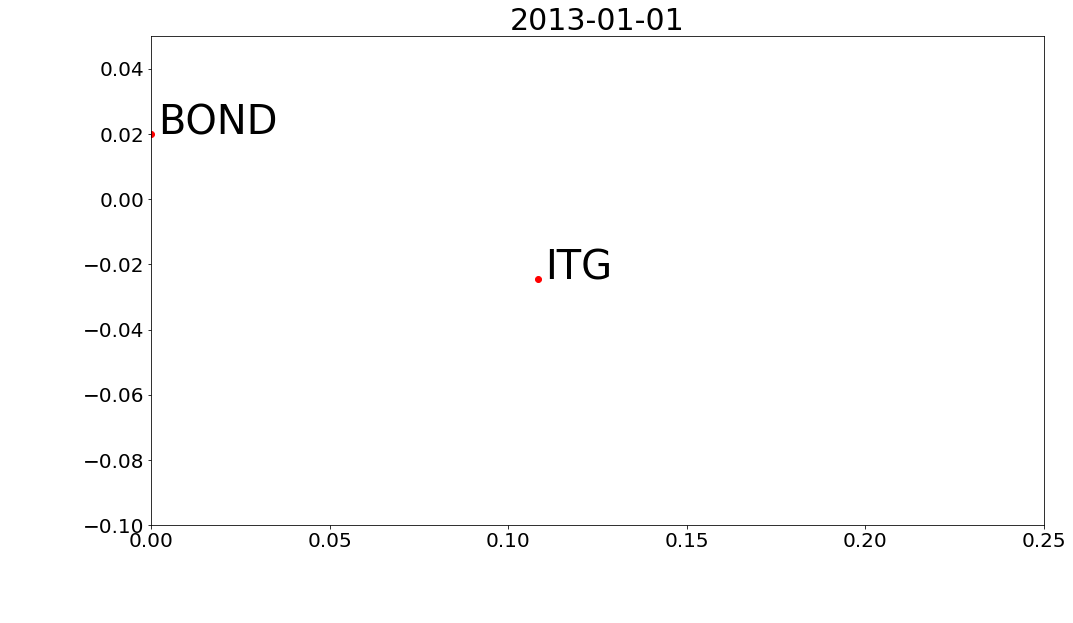

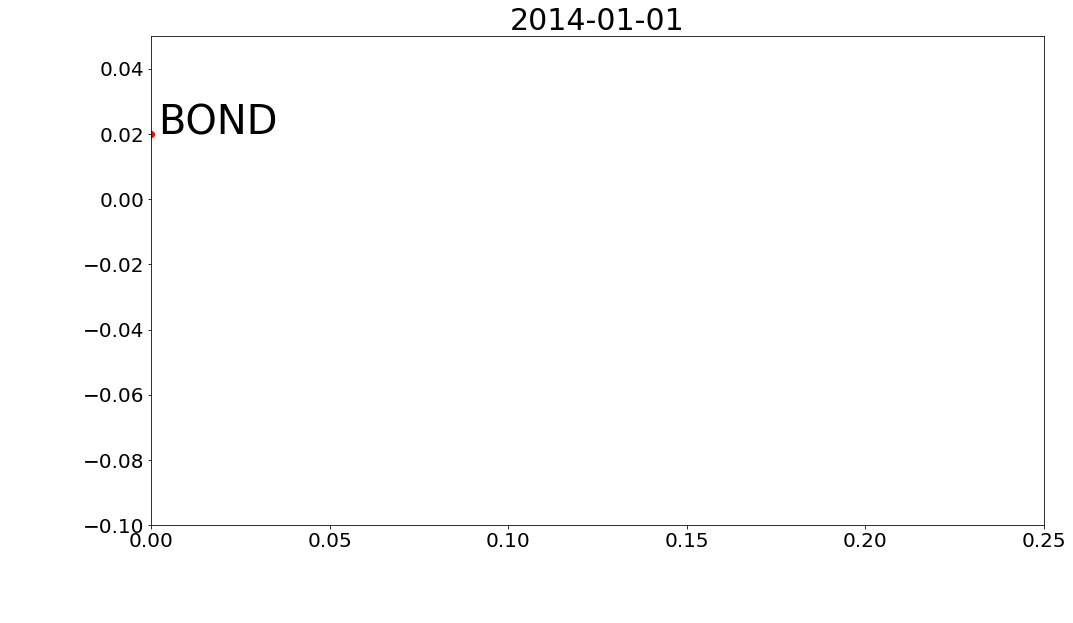

In [12]:
def plot_parameters(parameters_per_date, date):
    assert date in parameters_per_date
    parameters = parameters_per_date[date]
    fig, ax = plt.subplots(figsize=(16, 9))
    plt.title(date, fontsize=30)
    plt.xlim(0, 0.25)
    plt.ylim(-0.1, 0.05)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    for name, params in parameters.items():
        assert 'risk' in params
        assert 'return' in params
        plt.plot(params['risk'], params['return'], 'ro')
        ax.annotate(name.upper(), (params['risk'] + 0.002, params['return']), size=40)
    plt.show()

for date in dates:
    plot_parameters(parameters_per_date, date)

### Macierz korelacji

In [13]:
corr_matrices

{'2010-06-01':                          itg        pxm        pzu bond
                   Zamkniecie Zamkniecie Zamkniecie     
 (itg, Zamkniecie)   1.000000   0.184749   0.294264  0.0
 (pxm, Zamkniecie)   0.184749   1.000000   0.232355  0.0
 (pzu, Zamkniecie)   0.294264   0.232355   1.000000  0.0
 -1                  0.000000   0.000000   0.000000  0.0,
 '2012-01-01':                          itg        pxm        pzu bond
                   Zamkniecie Zamkniecie Zamkniecie     
 (itg, Zamkniecie)   1.000000   0.155402   0.332990  0.0
 (pxm, Zamkniecie)   0.155402   1.000000   0.189206  0.0
 (pzu, Zamkniecie)   0.332990   0.189206   1.000000  0.0
 -1                  0.000000   0.000000   0.000000  0.0,
 '2013-01-01':                          itg        pxm        pzu bond
                   Zamkniecie Zamkniecie Zamkniecie     
 (itg, Zamkniecie)   1.000000   0.172277   0.304136  0.0
 (pxm, Zamkniecie)   0.172277   1.000000   0.332422  0.0
 (pzu, Zamkniecie)   0.304136   0.332422   1

In [14]:
parameters_per_date

{'2010-06-01': {'bond': {'return': 0.02, 'risk': 0.0},
  'itg': {'return': 0.25324631761975658, 'risk': 0.098045542243340653},
  'pxm': {'return': -0.47522495238170503, 'risk': 0.20049041102973145},
  'pzu': {'return': 0.18626673660698168, 'risk': 0.058980005586287104}},
 '2012-01-01': {'bond': {'return': 0.02, 'risk': 0.0},
  'itg': {'return': 0.1698120570053685, 'risk': 0.10145764003399668},
  'pxm': {'return': -0.51403464128683507, 'risk': 0.22559944247130248},
  'pzu': {'return': 0.28696822447725001, 'risk': 0.05959393570960754}},
 '2013-01-01': {'bond': {'return': 0.02, 'risk': 0.0},
  'itg': {'return': -0.024620035630732229, 'risk': 0.1084192824866633},
  'pxm': {'return': -0.5500252252184028, 'risk': 0.2144155943987465},
  'pzu': {'return': 0.177481088448318, 'risk': 0.060224235895275015}},
 '2014-01-01': {'bond': {'return': 0.02, 'risk': 0.0},
  'itg': {'return': -0.50123534078467102, 'risk': 0.083482222647407456},
  'pxm': {'return': -0.4285761604724011, 'risk': 0.100045404039

In [15]:
def calculate_weighted_params(weights, returns, risks, correlation):
    n = len(weights)
    assert(n > 0)
    weighted_return = np.sum(weights * returns)
    weighted_risk = np.sqrt(np.sum(
            [np.sum([weights[i] * weights[j] * risks[i] * risks[j] * correlation[i, j]
                 for j in range(n)])
         for i in range(n)]))
    return weighted_risk, weighted_return

In [16]:
def calculate_portfolios(returns, risks, correlation, plot_density=10):
    for w1 in np.linspace(-1.00, 1.0, plot_density):
        for w2 in np.linspace(-1.00, 1.00, plot_density):
            for w3 in np.linspace(-1.00, 1.00, plot_density):
                weights = np.array([w1, w2, w3, 1 - w1 - w2 - w3])
                assert np.sum(weights) - 1.0 < 10e-4
                yield (tuple(weights), tuple(calculate_weighted_params(weights, returns, risks, correlation)))

In [17]:
def calculate_portfolios_from_date(date, data_frames, plot_density=10):
    return list(calculate_portfolios(
        np.array([parameters_per_date[date][k]['return'] for k in keys]),
        np.array([parameters_per_date[date][k]['risk'] for k in keys]),
        corr_matrices[date].as_matrix(),
        plot_density))

In [18]:
def split_portfolios(portfolios):
    portfolios_set = set(portfolios)
    best = lambda x: not any([p[1][0] <= x[1][0] and x[1][1] <= p[1][1] for p in portfolios_set - set([x])])
    optimals = set(filter(best, portfolios))
    return (optimals, portfolios_set - optimals)

In [19]:
def plot_portfolios(portfolios):
    optimals, non_optimals = split_portfolios(portfolios)
    assert len(optimals) > 0
    assert len(non_optimals) > 0
    for k, v in non_optimals:
        plt.plot(*v, 'ro')
    for k, v in optimals:
        plt.plot(*v, 'go')

In [20]:
def plot_portfolios_from_date(date, data_frames, plot_density=10):
    print(keys)
    returns = np.array([parameters_per_date[date][k]['return'] for k in keys])
    risks = np.array([parameters_per_date[date][k]['risk'] for k in keys])

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title(date)
    for name, params in parameters_per_date[date].items():
        plt.plot(params['risk'], params['return'], 'ro')
        ax.annotate(name, (params['risk'], params['return']))
    
    portfolios = tuple(calculate_portfolios(returns, risks, corr_matrices[date].as_matrix(), plot_density))
    plot_portfolios(portfolios)

### Optymalne portfele bez pozycji krótkich, dla akcji ITG, PXM i PZU

In [21]:
import random
density = 10
[random.choice(list(split_portfolios(calculate_portfolios_from_date('2014-01-01', data_frames, density))[0])) for _ in range(2)]

[((0.77777777777777768,
   -0.33333333333333337,
   -0.77777777777777779,
   1.3333333333333335),
  (0.068585538608030946, 0.69839448848639196)),
 ((1.0, 0.11111111111111116, -0.77777777777777779, 0.66666666666666663),
  (0.052286843664666571, 0.53430268794207481))]

### Efficient frontier bez pozycji krótkich, dla akcji ITG, PXM i PZU

2010-06-01
0.00000 0.00000 0.00000 1.00000 | 0.00000 0.02000
0.14286 0.00000 0.00000 0.85714 | 0.00843 0.04375
0.00000 0.00000 0.14286 0.85714 | 0.01401 0.05332
0.28571 0.00000 0.00000 0.71429 | 0.01685 0.06750
0.14286 0.00000 0.14286 0.71429 | 0.01835 0.07707
0.28571 0.00000 0.14286 0.57143 | 0.02488 0.10083
0.14286 -0.14286 0.00000 1.00000 | 0.02832 0.11450
0.00000 -0.14286 0.14286 1.00000 | 0.02881 0.12407
0.14286 -0.14286 0.14286 0.85714 | 0.02969 0.14782
0.28571 -0.14286 0.14286 0.71429 | 0.03278 0.17157
0.14286 -0.14286 0.28571 0.71429 | 0.03678 0.18114
0.42857 -0.14286 0.14286 0.57143 | 0.03755 0.19532
0.28571 -0.14286 0.28571 0.57143 | 0.04020 0.20489
0.57143 -0.14286 0.14286 0.42857 | 0.04344 0.21908
0.42857 -0.14286 0.28571 0.42857 | 0.04495 0.22865
0.71429 -0.14286 0.14286 0.28571 | 0.05006 0.24283
0.57143 -0.14286 0.28571 0.28571 | 0.05067 0.25240
0.42857 -0.14286 0.42857 0.28571 | 0.05498 0.26197
0.71429 -0.14286 0.28571 0.14286 | 0.05706 0.27615
0.57143 -0.14286 0.42857 0

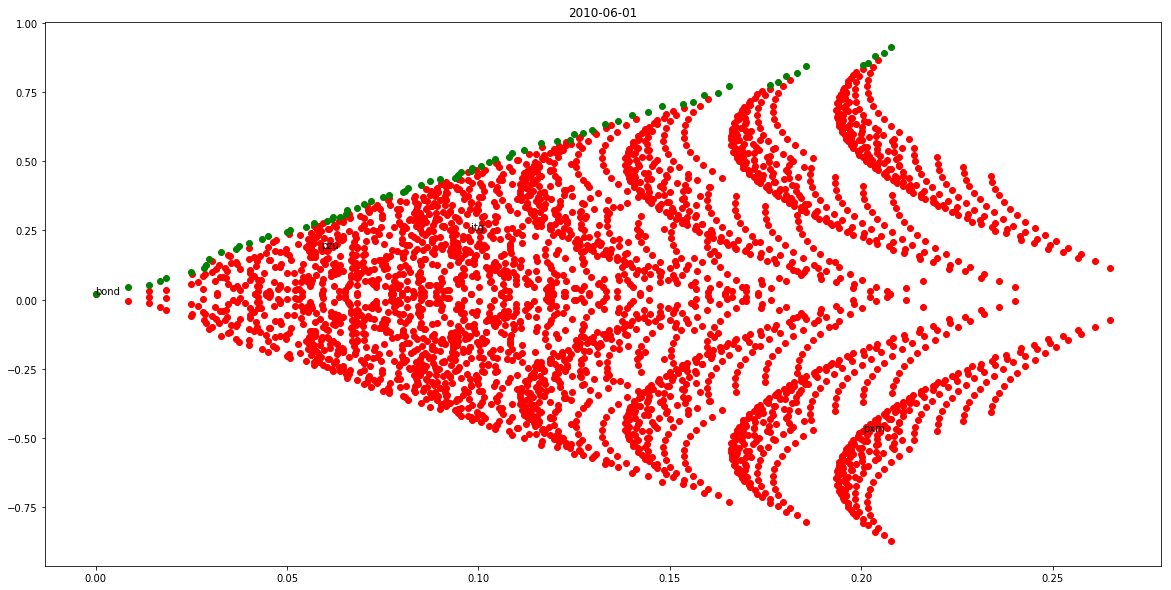

2012-01-01
0.00000 0.00000 0.00000 1.00000 | 0.00000 0.02000
0.14286 0.00000 0.00000 0.85714 | 0.00851 0.05814
0.28571 0.00000 0.00000 0.71429 | 0.01703 0.09628
0.42857 0.00000 -0.14286 0.71429 | 0.02482 0.11301
0.42857 0.00000 0.00000 0.57143 | 0.02554 0.13441
0.14286 -0.14286 0.00000 1.00000 | 0.03203 0.13443
0.57143 0.00000 -0.14286 0.57143 | 0.03226 0.15115
0.42857 0.00000 0.14286 0.42857 | 0.03330 0.15582
0.14286 -0.14286 0.14286 0.85714 | 0.03378 0.15583
0.28571 -0.14286 0.00000 0.85714 | 0.03403 0.17257
0.28571 -0.14286 0.14286 0.71429 | 0.03682 0.19397
0.42857 -0.14286 0.00000 0.71429 | 0.03788 0.21071
0.42857 -0.14286 0.14286 0.57143 | 0.04141 0.23211
0.57143 -0.14286 0.00000 0.57143 | 0.04310 0.24884
0.57143 -0.14286 0.14286 0.42857 | 0.04711 0.27025
0.71429 -0.14286 0.00000 0.42857 | 0.04924 0.28698
0.71429 -0.14286 0.14286 0.28571 | 0.05356 0.30838
0.85714 -0.14286 0.00000 0.28571 | 0.05600 0.32512
0.85714 -0.14286 0.14286 0.14286 | 0.06052 0.34652
1.00000 -0.14286 0.00000 

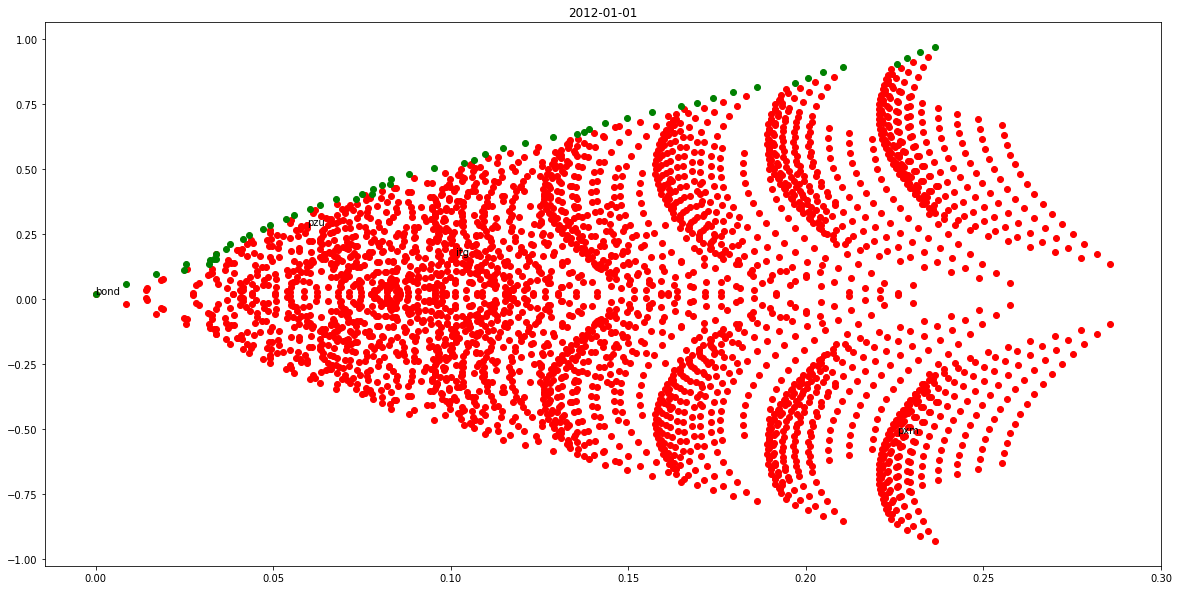

2013-01-01
0.00000 0.00000 0.00000 1.00000 | 0.00000 0.02000
0.14286 0.00000 0.00000 0.85714 | 0.00860 0.04250
0.14286 0.00000 -0.14286 1.00000 | 0.01526 0.04887
0.28571 0.00000 0.00000 0.71429 | 0.01721 0.06499
0.28571 0.00000 -0.14286 0.85714 | 0.01934 0.07137
0.42857 0.00000 -0.14286 0.71429 | 0.02575 0.09387
0.00000 -0.14286 0.14286 1.00000 | 0.02937 0.09506
0.14286 -0.14286 0.00000 1.00000 | 0.03036 0.12393
0.28571 -0.14286 0.00000 0.85714 | 0.03245 0.14643
0.42857 -0.14286 0.00000 0.71429 | 0.03650 0.16892
0.42857 -0.14286 -0.14286 0.85714 | 0.04055 0.17530
0.57143 -0.14286 0.00000 0.57143 | 0.04194 0.19142
0.57143 -0.14286 -0.14286 0.71429 | 0.04461 0.19780
0.71429 -0.14286 0.00000 0.42857 | 0.04832 0.21392
0.71429 -0.14286 -0.14286 0.57143 | 0.04985 0.22029
0.85714 -0.14286 0.00000 0.28571 | 0.05530 0.23642
0.85714 -0.14286 -0.14286 0.42857 | 0.05592 0.24279
0.85714 -0.14286 -0.28571 0.57143 | 0.06063 0.24916
0.42857 -0.28571 0.00000 0.85714 | 0.06224 0.25036
1.00000 -0.14286 -

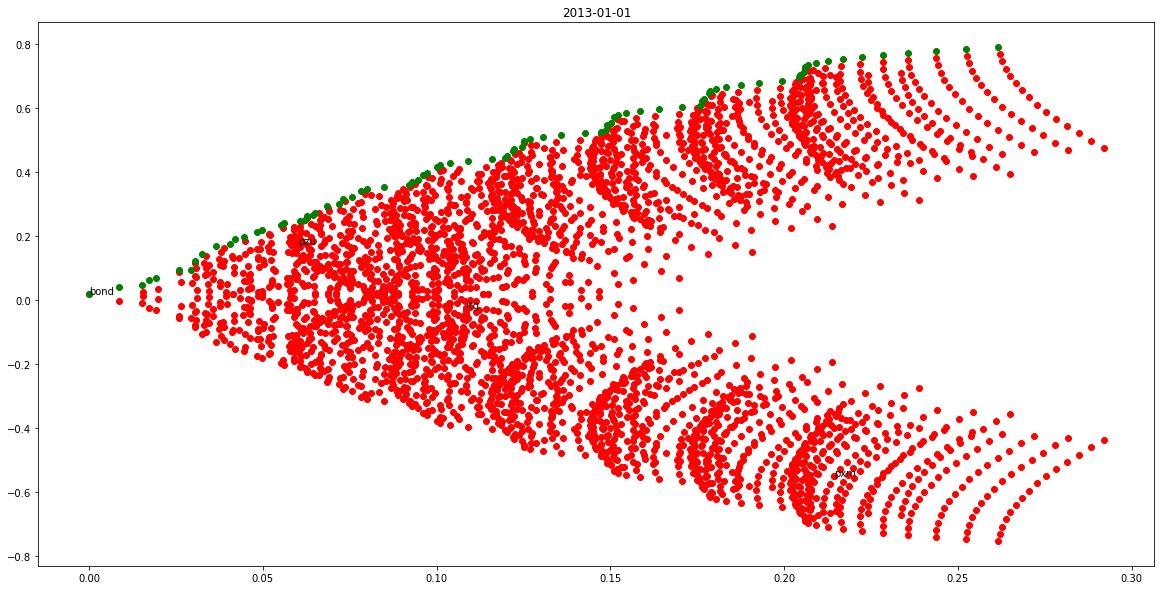

2014-01-01
0.00000 0.00000 0.00000 1.00000 | 0.00000 0.02000
0.14286 0.00000 0.00000 0.85714 | 0.00758 0.04268
0.14286 0.00000 -0.14286 1.00000 | 0.00956 0.11714
0.28571 0.00000 -0.14286 0.85714 | 0.01248 0.13982
0.42857 0.00000 -0.14286 0.71429 | 0.01830 0.16249
0.14286 -0.14286 -0.14286 1.14286 | 0.01911 0.18122
0.28571 0.00000 -0.28571 1.00000 | 0.01913 0.21428
0.42857 0.00000 -0.28571 0.85714 | 0.02090 0.23696
0.57143 0.00000 -0.28571 0.71429 | 0.02495 0.25963
0.28571 -0.14286 -0.28571 1.14286 | 0.02662 0.27836
0.42857 -0.14286 -0.28571 1.00000 | 0.02798 0.30104
0.42857 0.00000 -0.42857 1.00000 | 0.02869 0.31142
0.57143 0.00000 -0.42857 0.85714 | 0.03002 0.33409
0.71429 0.00000 -0.42857 0.71429 | 0.03307 0.35677
0.42857 -0.14286 -0.42857 1.14286 | 0.03515 0.37550
0.57143 -0.14286 -0.42857 1.00000 | 0.03628 0.39818
0.57143 0.00000 -0.57143 1.00000 | 0.03826 0.40856
0.71429 -0.14286 -0.42857 0.85714 | 0.03888 0.42085
0.71429 0.00000 -0.57143 0.85714 | 0.03934 0.43123
0.85714 0.00000 

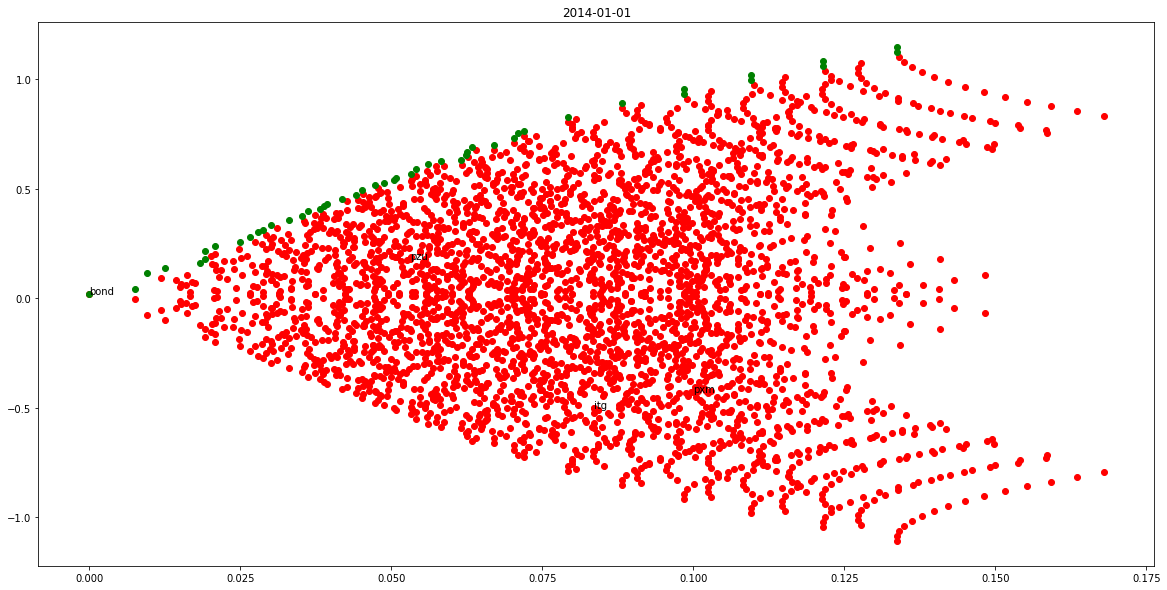

In [22]:
plot_density = 15

def portfolio_cmp(x):
    return (x[1][0], x[1][1])

for date in dates:
    optimal_portfolios_on_date = list(split_portfolios(calculate_portfolios_from_date(date, data_frames, plot_density))[0])
    print(date)
    optimal_portfolios_on_date.sort(key=portfolio_cmp)
    for port in optimal_portfolios_on_date:
        fmt_str = '{:.5f}'
        print(' '.join([fmt_str.format(k) for k in port[0]]) + ' | ' + ' '.join([fmt_str.format(k) for k in port[1]]))
    plot_portfolios_from_date(date, data_frames, plot_density)
    plt.show()